In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn

from torchvision import transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset

from tqdm import tqdm
from typing import Callable, List, Tuple

from model import BetaVAE, compute_loss


image_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])

data = CelebA(root="../dataset/", download=False, transform=image_transform)

In [2]:
from torch.utils.data import random_split

train_size = len(data) - 9
test_size = 9
train_data, test_data = random_split(data, [train_size, test_size])

In [3]:
print(len(train_data), len(test_data))

162761 9


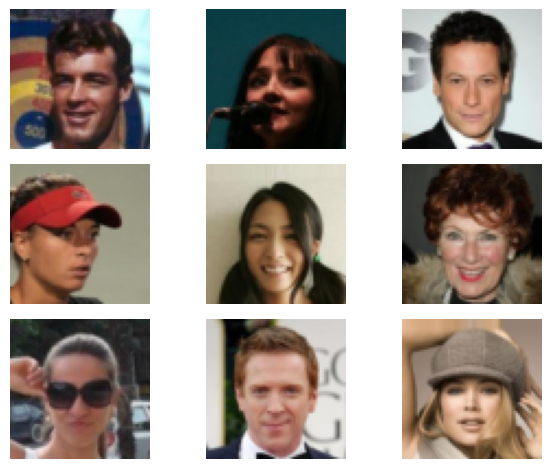

In [4]:
def imshow(imgs: List[th.Tensor]):
    n = int(np.sqrt(len(imgs)))
    assert n * (len(imgs) // n) == len(imgs)
    for i in range(len(imgs)):
        plt.subplot(n, len(imgs) // n, i + 1)
        plt.imshow(imgs[i].permute(1, 2, 0))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

imshow([train_data[i][0] for i in range(9)])

In [5]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [15]:
def show_reconstructions(model: nn.Module,
                         test_sample: Subset = test_data,
                         device: th.device = device):
    with th.no_grad():
        imgs = []
        for i in range(9):
            img = test_sample[i][0].unsqueeze(0).to(device)
            recon, _, __ = model(img)
            imgs.append(recon.cpu().squeeze())

    imshow(imgs)

In [16]:
def train(model: nn.Module,
          optimizer: th.optim.Optimizer,
          scheduler: th.optim.lr_scheduler,
          train_loader: DataLoader,
          epochs: int = 10,
          beta: float = 1.0,
          device: th.device = device):

    model.train()
    losses = []
    for epoch in range(epochs):
        desc = f"Epoch {epoch + 1}/{epochs}"
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=desc, leave=True)
        epoch_loss = 0

        for i, (img, _) in progress_bar:
            img = img.to(device)
            optimizer.zero_grad()
            loss, kl_div, recon_loss = compute_loss(model, img, beta)
            loss.backward()
            th.nn.utils.clip_grad_norm_(model.parameters(), 10)
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item(),
                                     recon_loss=recon_loss.mean().item(),
                                     kl_div=kl_div.mean().item())

        scheduler.step(loss)
        losses.append(epoch_loss / len(train_loader))

        if epoch % 10 == 0:
            show_reconstructions(model, test_data, device)

    return losses

In [17]:
th.random.manual_seed(11)
batch_size = 512
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
# data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [18]:
model = BetaVAE(latent_dim=4,
                net_arch=[3*64*64, 1024, 512, 256, 128],
                activation=nn.Softplus,
                batch_norm=True,
                layer_type="linear").to(device)

optimizer = th.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    patience=3,
                                                    factor=0.25,
                                                    verbose=True)

model

BetaVAE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=1024, bias=False)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=1024, out_features=512, bias=False)
    (4): Softplus(beta=1, threshold=20)
    (5): Linear(in_features=512, out_features=256, bias=False)
    (6): Softplus(beta=1, threshold=20)
    (7): Linear(in_features=256, out_features=128, bias=False)
    (8): Softplus(beta=1, threshold=20)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mu): Linear(in_features=128, out_features=4, bias=True)
  (log_var): Linear(in_features=128, out_features=4, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Unflatten(dim=1, unflattened_size=torch.Size([128]))
    (3): Linear(in_features=128, out_features=256, bias=False)
    (4): Softplus(beta=1, threshold=20)
    (5): Linear(in_features=256, out_features

Epoch 1/100: 100%|██████████| 318/318 [00:10<00:00, 30.09it/s, kl_div=152, loss=7.79e+3, recon_loss=7.64e+3]  


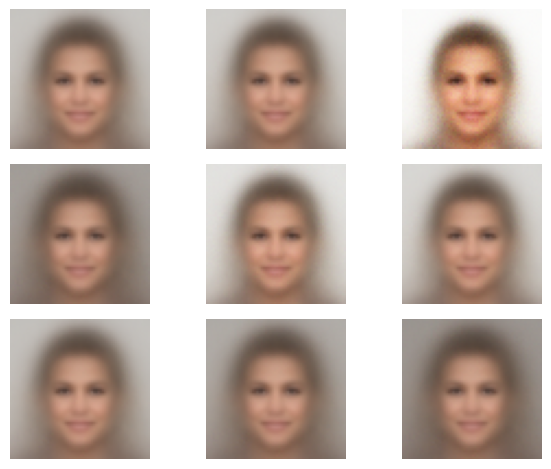

Epoch 2/100:  14%|█▍        | 45/318 [00:01<00:09, 30.20it/s, kl_div=132, loss=7.65e+3, recon_loss=7.52e+3]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7feb1508f310>
Traceback (most recent call last):
  File "/home/bluesun/anaconda3/envs/rl/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/bluesun/anaconda3/envs/rl/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/bluesun/anaconda3/envs/rl/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7feb1508f310>
Traceback (most recent call last):
  File "/home/bluesun/anaconda3/envs/rl/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466

Epoch 00008: reducing learning rate of group 0 to 2.5000e-04.



Epoch 9/100:  10%|█         | 33/318 [00:01<00:12, 23.17it/s, kl_div=136, loss=7.7e+3, recon_loss=7.56e+3] Traceback (most recent call last):
  File "/home/bluesun/anaconda3/envs/rl/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/bluesun/anaconda3/envs/rl/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/bluesun/anaconda3/envs/rl/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7feb1508f310>
Traceback (most recent call last):
  File "/home/bluesun/anaconda3/envs/rl/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/bluesun/anaconda3/envs/rl/lib/pyt

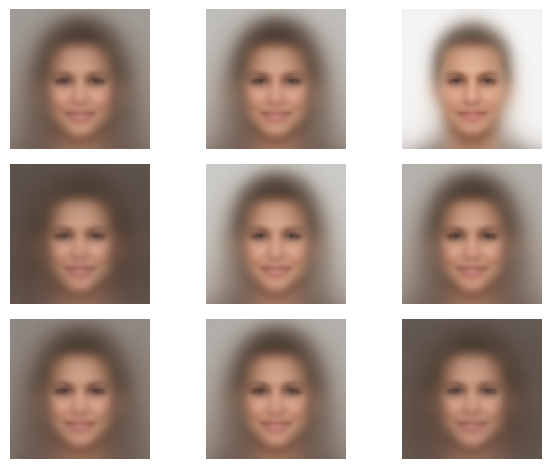

Epoch 12/100: 100%|██████████| 318/318 [00:11<00:00, 27.24it/s, kl_div=144, loss=7.61e+3, recon_loss=7.47e+3]

Epoch 00012: reducing learning rate of group 0 to 6.2500e-05.



Epoch 20/100: 100%|██████████| 318/318 [00:11<00:00, 26.96it/s, kl_div=140, loss=7.61e+3, recon_loss=7.47e+3]

Epoch 00020: reducing learning rate of group 0 to 1.5625e-05.



Epoch 21/100: 100%|██████████| 318/318 [00:11<00:00, 27.03it/s, kl_div=142, loss=7.59e+3, recon_loss=7.45e+3]


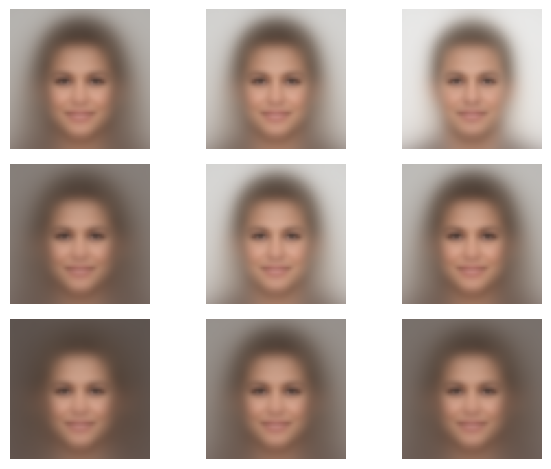

Epoch 24/100: 100%|██████████| 318/318 [00:11<00:00, 27.17it/s, kl_div=140, loss=7.61e+3, recon_loss=7.47e+3]

Epoch 00024: reducing learning rate of group 0 to 3.9063e-06.



Epoch 28/100: 100%|██████████| 318/318 [00:11<00:00, 28.40it/s, kl_div=142, loss=7.62e+3, recon_loss=7.48e+3]

Epoch 00028: reducing learning rate of group 0 to 9.7656e-07.



Epoch 31/100: 100%|██████████| 318/318 [00:11<00:00, 28.45it/s, kl_div=145, loss=7.6e+3, recon_loss=7.46e+3] 


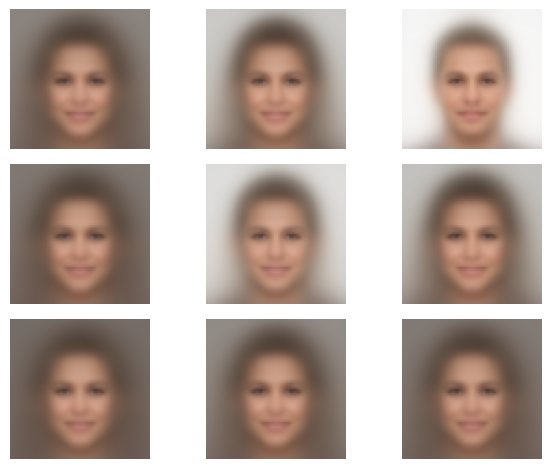

Epoch 32/100: 100%|██████████| 318/318 [00:11<00:00, 28.39it/s, kl_div=137, loss=7.55e+3, recon_loss=7.42e+3]

Epoch 00032: reducing learning rate of group 0 to 2.4414e-07.



Epoch 38/100: 100%|██████████| 318/318 [00:11<00:00, 28.24it/s, kl_div=131, loss=7.63e+3, recon_loss=7.5e+3] 

Epoch 00038: reducing learning rate of group 0 to 6.1035e-08.



Epoch 41/100: 100%|██████████| 318/318 [00:11<00:00, 28.26it/s, kl_div=139, loss=7.59e+3, recon_loss=7.46e+3]


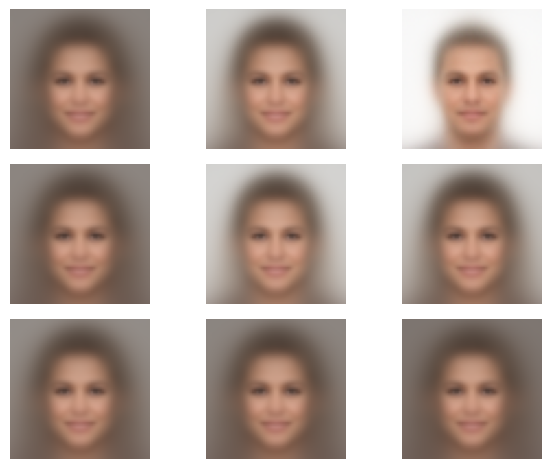

Epoch 42/100: 100%|██████████| 318/318 [00:11<00:00, 27.73it/s, kl_div=138, loss=7.66e+3, recon_loss=7.52e+3]

Epoch 00042: reducing learning rate of group 0 to 1.5259e-08.



Epoch 46/100: 100%|██████████| 318/318 [00:11<00:00, 27.76it/s, kl_div=132, loss=7.62e+3, recon_loss=7.49e+3]

Epoch 00046: reducing learning rate of group 0 to 3.8147e-09.



Epoch 51/100: 100%|██████████| 318/318 [00:11<00:00, 27.76it/s, kl_div=134, loss=7.59e+3, recon_loss=7.46e+3]


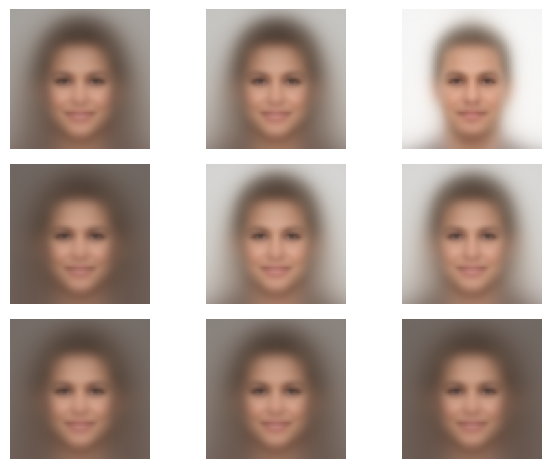

Epoch 61/100: 100%|██████████| 318/318 [00:11<00:00, 28.00it/s, kl_div=139, loss=7.6e+3, recon_loss=7.47e+3] 


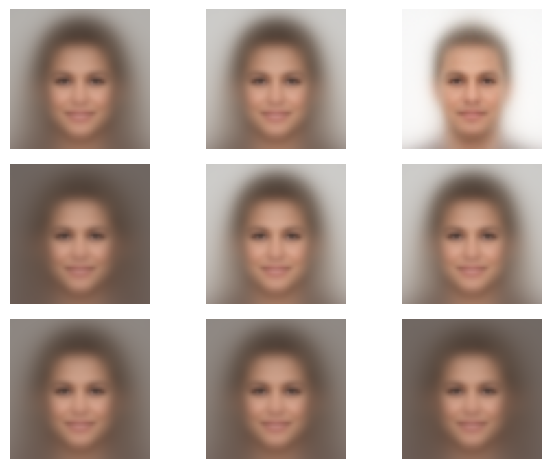

Epoch 71/100: 100%|██████████| 318/318 [00:11<00:00, 28.21it/s, kl_div=141, loss=7.63e+3, recon_loss=7.49e+3]


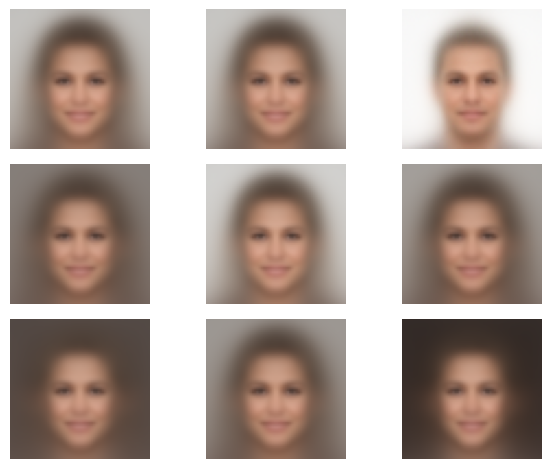

Epoch 81/100: 100%|██████████| 318/318 [00:11<00:00, 27.86it/s, kl_div=141, loss=7.65e+3, recon_loss=7.51e+3]


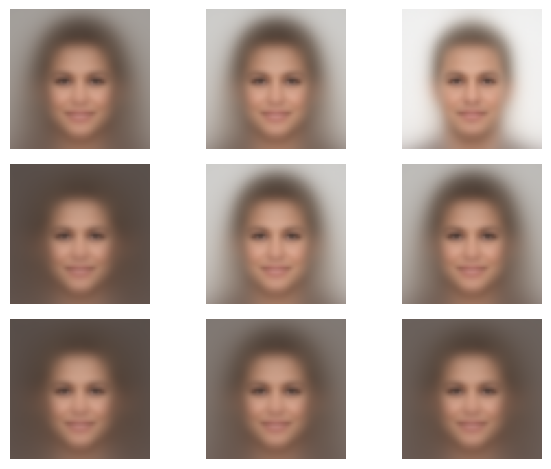

Epoch 91/100: 100%|██████████| 318/318 [00:11<00:00, 28.29it/s, kl_div=141, loss=7.53e+3, recon_loss=7.39e+3]


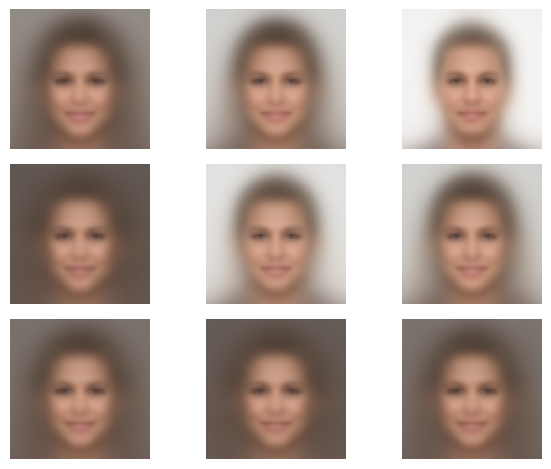

Epoch 100/100: 100%|██████████| 318/318 [00:11<00:00, 27.80it/s, kl_div=141, loss=7.62e+3, recon_loss=7.48e+3]


In [19]:
history = train(model, optimizer, scheduler, data_loader, epochs=100, beta=100.0)

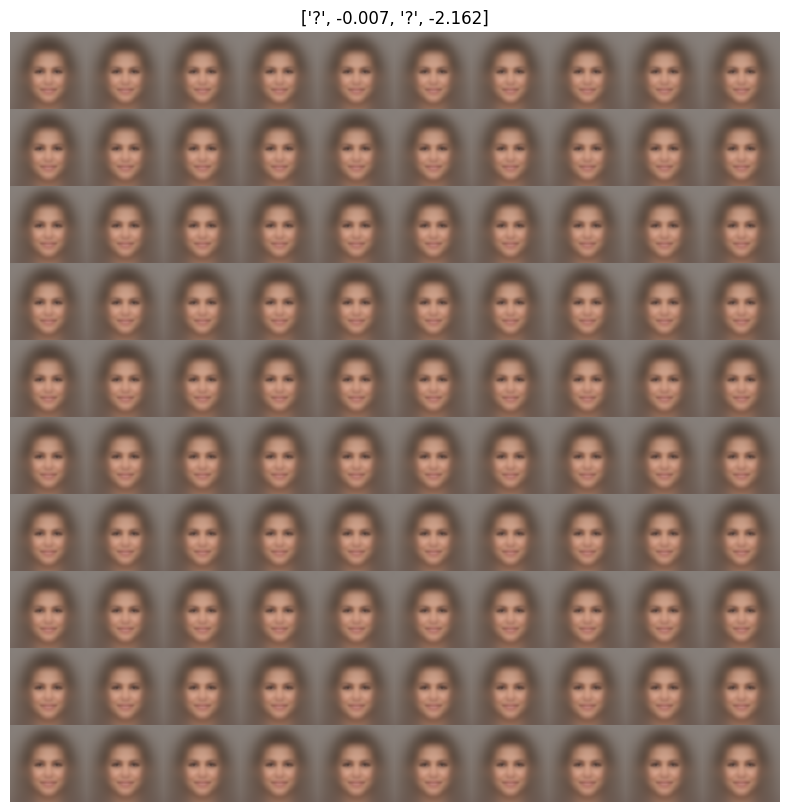

In [40]:
def plot_latent_space(model, n, dims, default_z, tile_size=64, return_ims=False):
    norm = th.distributions.Normal(0, 1)
    grid_x = norm.icdf(th.linspace(0.05, 0.95, n))
    grid_y = norm.icdf(th.linspace(0.05, 0.95, n))
    image_width = tile_size * n
    image_height = image_width
    image = th.zeros(3, image_height, image_width)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = default_z.clone()
            z[dims[0]] = xi
            z[dims[1]] = yi
            x_hat = model.decoder(z[None, ...])
            x_hat = transforms.functional.rotate(x_hat[0], 90)
            image[
                :,
                i * tile_size : (i + 1) * tile_size,
                j * tile_size : (j + 1) * tile_size,
            ] = x_hat.squeeze().detach().cpu()

    # plt.title(f"{[round(x, 3) if i in dims else '?' for i, x in enumerate(default_z)]}")

    plt.figure(figsize=(10, 10))
    plt.title(f"{[round(x, 3) if i not in dims else '?' for i, x in enumerate(default_z.cpu().numpy())]}")
    plt.axis("off")
    ims = plt.imshow(image.cpu().permute(2, 1, 0), animated=return_ims)
    if return_ims:
        return ims
    plt.show()

plot_latent_space(model, 10, [0, 2], 5*th.randn(model.latent_dim).to(device))
